In [1]:
# !git clone https://github.com/VirtualRoyalty/TextGenESN.git
# %cd TextGenESN/
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import torch
import warnings
warnings.simplefilter('ignore')

## Dataset (males lastnames)
About ~9k lastnames

In [3]:
with open('datasets/russian_names.txt') as input_file:
    names = input_file.read()[3:-1].split('\n')
    names = [' ' + line for line in names]

In [6]:
names[:5]

[' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin', ' Abaimoff']

Name length ditribution

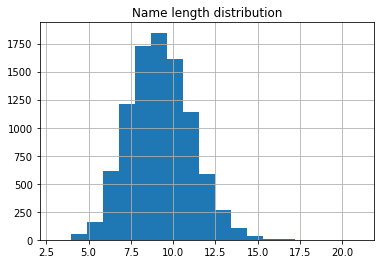

In [7]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=19)
plt.grid()
pass

## Preprocessing

In [8]:
#all unique characters go here
tokens     = list(set(''.join(names)))
num_tokens = len(tokens)
MAX_LENGTH = max(map(len, names))
print ('num_tokens = ', num_tokens, MAX_LENGTH)

num_tokens =  51 21


### Character -> id

In [9]:
from utils import train
train = imp.reload(train)

token_to_id = {token: idx for idx, token in enumerate(tokens)}
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"
print("Seems alright!")
print('\n'.join(names[::2000]))
print(train.to_matrix(names[::2000], token_to_id))

## Echo State Network with SORM

### Create ESN instance

In [152]:
%%time
from net import esn
import importlib as imp
esn = imp.reload(esn)


device           = torch.device('cuda')
n_in             = len(tokens)
n_res            = 400
lin_size         = 64
leaking_rate     = 0.9
ro_hidden_layers = 1
spec_radius      = 0.99
density          = 0.05


net = esn.GenESN(n_in=n_in, n_res=n_res , n_out=n_in, 
                 ro_hidden_layers=ro_hidden_layers,
                 leaking_rate=leaking_rate, 
                 spec_radius=spec_radius,
                 lin_size=lin_size, 
                 density=density, 
                 device=device) 

net.to(device)
print(net)

Internal reservoir set
Reservoir has 2633 non zero values (1.65%)
GenESN(
  (readout_in): Linear(in_features=400, out_features=64, bias=True)
  (readout_out): Linear(in_features=64, out_features=51, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax()
)
Wall time: 5.8 s


In [153]:
lr           = 1e-3
opt          = torch.optim.Adam(net.parameters(), lr=lr)
lr_scheduler = train.scheduler(opt, patience=200)
MAX_LENGTH   = max(map(len, names))
history      = []

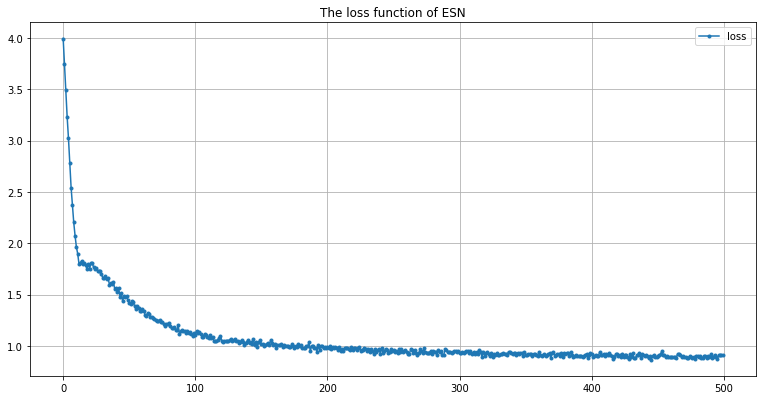

Wall time: 31.5 s


In [154]:
%%time
train = imp.reload(train)

n_epoch    = 500
batch_size = 300

train.trainESN(net, 
               data=names,
               tokens=tokens,
               token_to_id=token_to_id,
               max_length=MAX_LENGTH,
               n_epoch=n_epoch, 
               batch_size=batch_size, 
               opt=opt,
               lr_scheduler=lr_scheduler, 
               history=history, 
               legend=False)

### ESN generating

In [155]:
from utils import gen
gen = imp.reload(gen)

for _ in range(10):
    print(gen.generate_sample(net, 
                              max_length=MAX_LENGTH,
                              tokens=tokens,
                              token_to_id=token_to_id,
                              temperature=0.9, 
                              seed_phrase=' '))

 Zusyarchukov        
 Bakmaid             
 Kovchev             
 Adtchelnov          
 Likhlastka          
 Masgushaev          
 Mepchia             
 Morrimerev          
 Achurchovin         
 Yudahamku           


In [156]:
for _ in range(10):
    print(gen.generate_sample(net, 
                              max_length=MAX_LENGTH,
                              tokens=tokens,
                              token_to_id=token_to_id,
                              temperature=0.95, 
                              seed_phrase=' Alp'))

 Alpulin             
 Alpanan             
 Alpomsav            
 Alpene              
 Alpolyan            
 Alpakin             
 Alpalen             
 Alparov             
 Alpaglohnko         
 Alpekhantos Bichehka


### GridSearch Optimization hyperparams

In [117]:
from utils import optimizer
optimizer = imp.reload(optimizer)


optimizer.GridSearchOptimizer(esn.GenESN,
                              data=names,
                              n_epoch=500,
                              batch_size=300,
                              max_length=MAX_LENGTH,
                              tokens=tokens,
                              token_to_id=token_to_id,
                              in_out=(len(tokens), len(tokens)),
                              learning_rate=1e-3,
                              n_res=[300],
                              lin_size=[64, 100, 210],
                              density=[0.05, 0.1, 0.2],
                              ro_hidden_layers=[1, 2, 3],
                              leaking_rate=[0.6, 0.9])

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 64, 'n_res': 300, 'ro_hidden_layers': 1}
Internal reservoir set
Reservoir has 1692 non zero values (1.88%)
Loss function value: 0.9419999718666077 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 64, 'n_res': 300, 'ro_hidden_layers': 2}
Internal reservoir set
Reservoir has 1447 non zero values (1.61%)
Loss function value: 0.9290000200271606 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 64, 'n_res': 300, 'ro_hidden_layers': 3}
Internal reservoir set
Reservoir has 1574 non zero values (1.75%)
Loss function value: 0.9409999847412109 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 100, 'n_res': 300, 'ro_hidden_layers': 1}
Internal reservoir set
Reservoir has 1593 non zero values (1.77%)
Loss function value: 0.9269999861717224 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 100, 'n_res': 300, 'ro_hidden_layers': 2}
Internal reservoir set
Reservoir has 1571 non zero values (1.75%)


### RNN implementation

In [86]:
import numpy as np
from random import sample
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from IPython.display import clear_output

class CharRNNCell(nn.Module):
    
    def __init__(self, 
                 num_tokens=len(tokens), 
                 embedding_size=16, 
                 rnn_num_units=64, 
                 device = torch.device('cuda:0')):
        super(self.__class__,self).__init__()
        
        self.num_units     = rnn_num_units
        self.embedding     = nn.Embedding(num_tokens, embedding_size).to(device)
        self.rnn_update    = nn.Linear(embedding_size + rnn_num_units, rnn_num_units).to(device)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens).to(device)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x).to(device)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1) 
        h_next  = self.rnn_update(x_and_h)         
        h_next  = F.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return Variable(torch.zeros(batch_size, self.num_units))

In [144]:

def lm_cross_entropy(pred, target):
    target_flat = target.view(-1)  # BatchSize*TargetLen
#     print(target_flat.shape)
    pred_flat = pred.reshape(pred.shape[0]*pred.shape[1], pred.shape[-1]) # BatchSize*TargetLen x VocabSize

    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)

In [145]:
def rnn_loop(rnn, batch_index):
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size).to(device)
    logprobs = []
    for x_t in batch_index.transpose(0, 1):
        hid_state, logp_next = rnn(x_t.to(device), hid_state.to(device))  
        logprobs.append(logp_next)
    return torch.stack(logprobs, dim=1)

In [146]:
def trainRNN(rnn, 
             n_epoch=500, 
             batch_size=300, 
             random_batching=True,
             max_length=MAX_LENGTH):

    for i in range(n_epoch):
        if random_batching:
            batch_ix = train.to_matrix(sample(names, batch_size), token_to_id, max_len=max_length)
            batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

            logp_seq = rnn_loop(rnn, batch_ix)

            predictions_logp   = logp_seq[:, :-1].to(device)
            actual_next_tokens = batch_ix[:, 1:].to(device)
            
            loss = lm_cross_entropy(predictions_logp, actual_next_tokens)
#             loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))
            loss.backward()
            opt.step()
            opt.zero_grad()

            history.append(loss.data.cpu().numpy())
            if (i + 1) % 100 == 0:
                clear_output(True)
                plt.figure(figsize=(13, 6.5))
                plt.grid()
                plt.plot(history, '.-', label='loss')
                plt.legend()
                plt.title('The loss function of Vanilla RNN')
                plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [147]:
char_rnn = CharRNNCell()
opt      = torch.optim.Adam(char_rnn.parameters())
history  = []

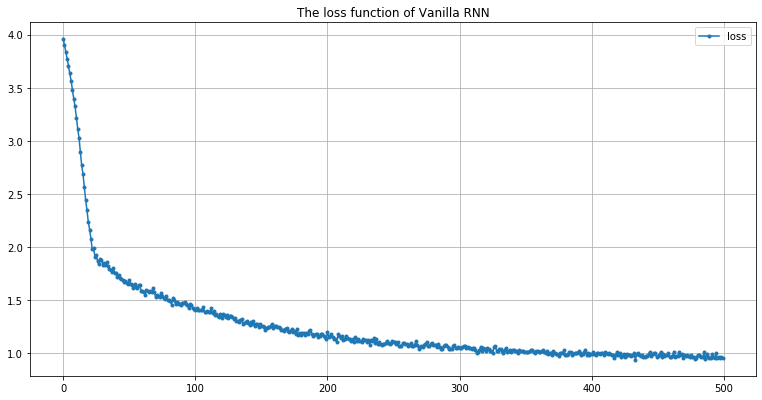

Wall time: 23.4 s


In [148]:
%%time
trainRNN(char_rnn, n_epoch=500, batch_size=300)

In [23]:
def generate_sample_rnn(char_rnn, 
                        seed_phrase=' ', 
                        max_length=MAX_LENGTH, 
                        temperature=1.0,
                        enforce_end=False, 
                        device=torch.device('cuda')): 
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state  = char_rnn.initial_state(batch_size=1).to(device)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    for _ in range(max_length - len(seed_phrase)):
        
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        
        if enforce_end and tokens[next_ix] == ' ':
            break
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
       
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [24]:
for _ in range(10):
    print(generate_sample_rnn(char_rnn,temperature=0.9,seed_phrase=' Alpero'))

 Alpero              
 Alperov             
 Alperovsev          
 Alperorilanko       
 Alperov             
 Alperov             
 Alperovsky          
 Alperov             
 Alperovsky          
 Alpero  e           


### Evaluate and compare generated results. Vanilla RNN VS ESN

In [46]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from nltk import bleu
from Levenshtein import ratio

In [29]:
n_gen = 10
t     = 0.9
rnn_generated = [generate_sample_rnn(char_rnn, 
                                     seed_phrase=' ', 
                                     temperature=t, 
                                     enforce_end=True) \
                 for x in range(n_gen)]
esn_generated = [gen.generate_sample(net, 
                                     max_length=MAX_LENGTH,
                                     tokens=tokens,
                                     token_to_id=token_to_id,
                                     seed_phrase=' ', 
                                     temperature=t, 
                                     enforce_end=True) \
                 for x in range(n_gen)]

In [30]:
rnn_generated[:3], esn_generated[:3]

([' Vidshin', ' Vyuholich', ' RoLonin'], [' Balantovy', ' Yasky', ' Antseki'])

In [49]:
def evaluate_gen(reference, candidates, is_sentence_bleu=False):
    sm_f      = SmoothingFunction()
    min_bleu  = 1
    score_lst = []
    for candidate in candidates:
        if is_sentence_bleu:
            score_lst.append(sentence_bleu(reference, candidate))
        else:
            score_lst.append(np.mean([bleu(ref, candidate, smoothing_function=sm_f.method1) 
                                      for ref in reference]))
    return score_lst

def evaluate_gen_lev(reference, candidates, is_sentence_bleu=False):
    sm_f      = SmoothingFunction()
    min_bleu  = 1
    score_lst = []
    for candidate in candidates:
        score_lst.append(np.mean([ratio(ref, candidate) 
                                      for ref in reference]))
    return score_lst
        

In [50]:
%time score_lst = evaluate_gen_lev(names, esn_generated)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 301 ms
Eval mean: 0.329 Eval min: 0.197 Eval max: 0.416


In [51]:
%time score_lst = evaluate_gen_lev(names, rnn_generated)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 291 ms
Eval mean: 0.328 Eval min: 0.205 Eval max: 0.416


In [52]:
%time score_lst = evaluate_gen(names, esn_generated, is_sentence_bleu=True)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 33.4 s
Eval mean: 0.742 Eval min: 2.47e-232 Eval max: 1.0


In [53]:
%time score_lst = evaluate_gen(names, rnn_generated, is_sentence_bleu=True)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 34.7 s
Eval mean: 0.627 Eval min: 2.47e-232 Eval max: 1.0


**Compare score by temperature**

In [157]:
%%time
n_gen            = 200
n_neg_sample     = 500
temperature      = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
is_sentence_bleu = True

rnn_gen_mean_lst = []
esn_gen_mean_lst = []
rnn_gen_lev_mean_lst = []
esn_gen_lev_mean_lst = []

for t in temperature:
    print('Temperature {}'.format(t))
    
    sample_data   = sample(names, n_neg_sample)
    rnn_generated = [generate_sample_rnn(char_rnn, 
                                         seed_phrase=' ', 
                                         temperature=t, 
                                         enforce_end=True) \
                     for x in range(n_gen)]
    score_lst     = evaluate_gen(sample_data, rnn_generated, is_sentence_bleu=is_sentence_bleu)
    score_lst_lev = evaluate_gen_lev(sample_data, rnn_generated)
    rnn_gen_mean_lst.append(np.mean(score_lst))
    rnn_gen_lev_mean_lst.append(np.mean(score_lst_lev))
    
    esn_generated = [gen.generate_sample(net, 
                                         max_length=MAX_LENGTH,
                                         tokens=tokens,
                                         token_to_id=token_to_id,
                                         seed_phrase=' ', 
                                         temperature=t, 
                                         enforce_end=True)
                     for x in range(n_gen)]
    score_lst     = evaluate_gen(sample_data, esn_generated, is_sentence_bleu=is_sentence_bleu)
    score_lst_lev = evaluate_gen_lev(sample_data, esn_generated)
    esn_gen_mean_lst.append(np.mean(score_lst))
    esn_gen_lev_mean_lst.append(np.mean(score_lst_lev))

Temperature 0.1
Temperature 0.2
Temperature 0.3
Temperature 0.4
Temperature 0.5
Temperature 0.6
Temperature 0.7
Temperature 0.8
Temperature 0.9
Temperature 1
Wall time: 1min 58s


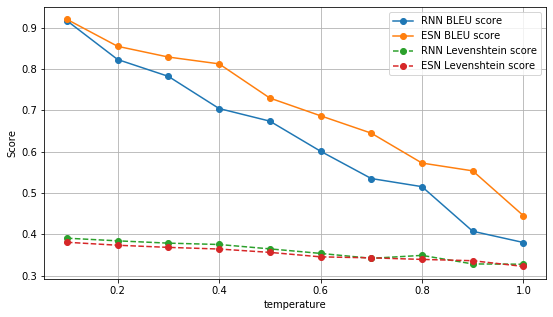

In [158]:
plt.figure(figsize=(9,5))
plt.plot(temperature, rnn_gen_mean_lst,'o-', label='RNN BLEU score')
plt.plot(temperature, esn_gen_mean_lst, 'o-',label='ESN BLEU score')
plt.plot(temperature, rnn_gen_lev_mean_lst,'o--', label='RNN Levenshtein score')
plt.plot(temperature, esn_gen_lev_mean_lst,'o--', label='ESN Levenshtein score')
plt.xlabel('temperature')
plt.ylabel('Score')
# plt.title('Evaluation score by temperature of generation')
plt.grid()
plt.legend()
pass

### Comparing different ESN settings 

In [69]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from datetime import datetime
train = imp.reload(train)

n_epoch    = 500
batch_size = 300

device = torch.device('cuda')
n_in = len(tokens)


_params = dict(n_res=[100, 200, 300],
              lin_size=[64],
              density=[0.05],
              ro_hidden_layers=[1],
              leaking_rate=[0.7],
              spec_radius=[0.97])

MAX_LENGTH   = max(map(len, names))

stat_dct = {'n_res':  [],
            'lsize':  [],
            'n_hid':  [],
            'loss':   [],
            'time':   [],
            'eval1':  [],
            'eval2':  [],
            'epoch':  [],
            'batch':  []}

for param in ParameterGrid(_params):
    print(param)
    tmp_net = esn.GenESN(n_in=n_in, n_out=n_in, 
                         n_res=param['n_res'],
                         ro_hidden_layers=param['ro_hidden_layers'],
                         lin_size=param['lin_size'],
                         density=param['density'],
                         leaking_rate=param['leaking_rate'],
                         spec_radius=param['spec_radius'],
                         device=device)
    tmp_net.to(device)
    
    lr           = 1e-3
    opt          = torch.optim.Adam(tmp_net.parameters(), lr=lr)
    lr_scheduler = train.scheduler(opt, patience=200)
    history      = []
    start_time = datetime.now()
    train.trainESN(tmp_net, 
                   data=names,
                   tokens=tokens,
                   token_to_id=token_to_id,
                   max_length=MAX_LENGTH,
                   n_epoch=n_epoch, 
                   batch_size=200, 
                   opt=opt,
                   lr_scheduler=lr_scheduler, 
                   history=history, 
                   plot_loss=False,
                   legend=True)
    end_time = datetime.now() - start_time
    n_gen = 100
    n_neg_sample = 200
    sample_data   = sample(names, n_neg_sample)
    esn_generated = [gen.generate_sample(tmp_net, 
                                         max_length=MAX_LENGTH,
                                         tokens=tokens,
                                         token_to_id=token_to_id,
                                         seed_phrase=' ', 
                                         temperature=t, 
                                         enforce_end=True)
                     for x in range(n_gen)]
    score_lst  = evaluate_gen(sample_data, esn_generated, is_sentence_bleu=is_sentence_bleu)
    lss = np.mean(history[-30:])
    print('Loss: {}\n'.format(round(lss, 3)))
    stat_dct['n_res'] += [param['n_res']]
    stat_dct['n_hid'] += [param['ro_hidden_layers']]
    stat_dct['lsize'] += [param['lin_size']]
    stat_dct['dens']  += [param['density']]
    stat_dct['loss']  += [lss]
    stat_dct['time']  += [end_time.total_seconds()]
    stat_dct['eval1'] += [np.mean(score_lst)]
    stat_dct['epoch'] += [n_epoch]
    stat_dct['batch'] += [batch_size]

{'density': 0.1, 'leaking_rate': 0.9, 'lin_size': 64, 'n_res': 100, 'ro_hidden_layers': 1, 'spec_radius': 0.99}
Internal reservoir set
Reservoir has 399 non zero values (3.99%)
Loss: 1.065999984741211

{'density': 0.1, 'leaking_rate': 0.9, 'lin_size': 64, 'n_res': 100, 'ro_hidden_layers': 2, 'spec_radius': 0.99}
Internal reservoir set
Reservoir has 396 non zero values (3.96%)
Loss: 1.0549999475479126

{'density': 0.1, 'leaking_rate': 0.9, 'lin_size': 64, 'n_res': 200, 'ro_hidden_layers': 1, 'spec_radius': 0.99}
Internal reservoir set
Reservoir has 1425 non zero values (3.56%)
Loss: 0.9890000224113464

{'density': 0.1, 'leaking_rate': 0.9, 'lin_size': 64, 'n_res': 200, 'ro_hidden_layers': 2, 'spec_radius': 0.99}
Internal reservoir set
Reservoir has 1384 non zero values (3.46%)
Loss: 0.9660000205039978

{'density': 0.1, 'leaking_rate': 0.9, 'lin_size': 64, 'n_res': 300, 'ro_hidden_layers': 1, 'spec_radius': 0.99}
Internal reservoir set
Reservoir has 2594 non zero values (2.88%)
Loss: 0.9

In [85]:
import pandas as pd
stats = pd.DataFrame.from_dict(stat_dct)
print(stats.to_markdown())

|    |   n_res |   lsize |   n_hid |     loss |    time |    eval1 |   epoch |   batch |
|---:|--------:|--------:|--------:|---------:|--------:|---------:|--------:|--------:|
|  0 |     100 |      64 |       1 | 1.06612  | 18.9109 | 0.246754 |     400 |     300 |
|  1 |     100 |      64 |       2 | 1.05503  | 29.5279 | 0.172037 |     400 |     300 |
|  2 |     200 |      64 |       1 | 0.988726 | 20.282  | 0.250696 |     400 |     300 |
|  3 |     200 |      64 |       2 | 0.965881 | 28.981  | 0.306121 |     400 |     300 |
|  4 |     300 |      64 |       1 | 0.941353 | 21.1722 | 0.338505 |     400 |     300 |
|  5 |     300 |      64 |       2 | 0.939905 | 30.0367 | 0.314232 |     400 |     300 |
|  6 |     500 |      64 |       1 | 0.910719 | 20.0426 | 0.357338 |     400 |     300 |
|  7 |     500 |      64 |       2 | 0.903433 | 29.2783 | 0.351072 |     400 |     300 |


## Quotes dataset

In [61]:
%%time
import nltk
nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize



with open('datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]
    
    
for i, quote in enumerate(quotes):
    
    quote      = word_tokenize(quote)
    proc_quote = []
    
    for j, token in enumerate(quote):
        
        token = list(filter(lambda char: char in list(string.ascii_letters), token))
        proc_quote.append(''.join(token))
        
    quote     = ' '.join(proc_quote)
    quotes[i] = quote.lower()


Wall time: 12.2 s


In [63]:
from random import sample
sample(quotes,5)

['my experience as a young actor on network television was that i could nt make it work  i was drowning as an actor ',
 'for some reason  the military seems more afraid of gay people than they are against terrorists  but they re very brave with the terrorists  if the terrorists ever got a hold of this information  they d get a platoon of lesbians to chase us out of baghdad ',
 'my goal is to be the best tv presenter  the best entertainer  the best singer  i still want to be the best dancer  i want to be the best at everything i do ',
 'legends die hard  they survive as truth rarely does ',
 'for i do not seek to understand in order to believe  but i believe in order to understand  for i believe this  unless i believe  i will not understand ']

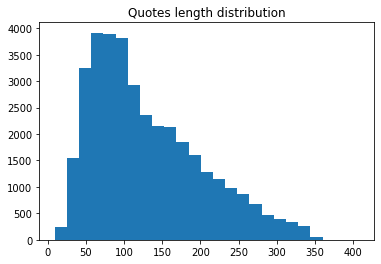

In [64]:
plt.title('Quotes length distribution')
plt.hist(list(map(len, quotes)), bins=25);

In [77]:
qtokens     = list(set(''.join(quotes)))
num_qtokens = len(qtokens)
qtoken_to_id = {token: idx for idx, token in enumerate(qtokens)}
print ('num_tokens = ', num_qtokens)
assert len(qtokens) == len(qtoken_to_id), "dictionaries must have same size"
for i in range(num_qtokens):
    assert qtoken_to_id[qtokens[i]] == i, "token identifier must be it's position in tokens list"

NameError: name 'quotes' is not defined

In [72]:
%%time
device           = torch.device('cuda')
n_in             = len(qtokens)
n_res            = 800
lin_size         = 30
ro_hidden_layers = 3
spec_radius      = 0.99
density          = 0.01
leaking_rate     = 1


net = esn.GenESN(n_in=n_in, n_res=n_res , n_out=n_in, 
                 ro_hidden_layers=ro_hidden_layers,
                 leaking_rate=leaking_rate, 
                 spec_radius=spec_radius,
                 lin_size=lin_size, 
                 density=density, 
                 device=device) 
net.to(device)
print(net)

Internal reservoir set
Reservoir has 2689 non zero values (0.42%)
GenESN(
  (readout_in): Linear(in_features=800, out_features=30, bias=True)
  (readout_out): Linear(in_features=30, out_features=27, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax()
)
Wall time: 38 s


In [73]:
lr = 1e-2
opt = torch.optim.Adam(net.parameters(), lr=lr)
lr_scheduler = scheduler(opt, patience=200)
MAX_QLENGTH = max(map(len, quotes))
history = []
quotes = sorted(quotes, key=len, reverse=False)
len(quotes[20000])

In [ ]:
%%time
n_epoch    = 1500
batch_size = 200

train.trainESN(  net, data=quotes[1000:15000], 
                 n_epoch=n_epoch,
                 batch_size=batch_size, 
                 lr_scheduler=lr_scheduler, 
                 history=history, 
                 random_batching=True,
                 max_length=MAX_QLENGTH, 
                 tokens=qtokens, 
                 token_to_id=qtoken_to_id,
                 opt=opt)

In [90]:
for _ in range(7):
    print(gen.generate_sample(net, 
                              max_length=MAX_QLENGTH, 
                              tokens=qtokens,
                              token_to_id=qtoken_to_id,
                              temperature=0.7, 
                              seed_phrase=' home'))
    print()

 home is    a                                                                                                                                                                                                                                                                                                                                                                                                           

 home lothero wor do  t dongs  d                                                                                                                                                                                                                                                                                                                                                                                        

 home wor  i                                                                                                                                                                        

In [0]:
GridSearchOptimizer(data=quotes,
                    MAX_LENGTH=MAX_QLENGTH,
                    token_to_id=qtoken_to_id, 
                    tokens=qtokens, 
                    n_epoch=500, 
                    n_res=[800], 
                    in_out=(len(qtokens), len(qtokens)),
                    lin_size=[30, 50, 100], 
                    leaking_rate=[0.7, 0.8, 0.9],
                    density=[0.01], 
                    ro_hidden_layers=[2,3,4])

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 30, 'n_res': 800, 'ro_hidden_layers': 2}
internal reservoir set
Reservoir has 3088 non zero values (0.48%)
Loss function value: 0.7799999713897705 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 30, 'n_res': 800, 'ro_hidden_layers': 3}
internal reservoir set
Reservoir has 3087 non zero values (0.48%)
Loss function value: 0.800000011920929 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 30, 'n_res': 800, 'ro_hidden_layers': 4}
internal reservoir set
Reservoir has 3171 non zero values (0.50%)
Loss function value: 0.7960000038146973 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 50, 'n_res': 800, 'ro_hidden_layers': 2}
internal reservoir set
Reservoir has 3115 non zero values (0.49%)
Loss function value: 0.7749999761581421 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 50, 'n_res': 800, 'ro_hidden_layers': 3}
internal reservoir set
Reservoir has 3166 non zero values (0.49%)
Los